In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

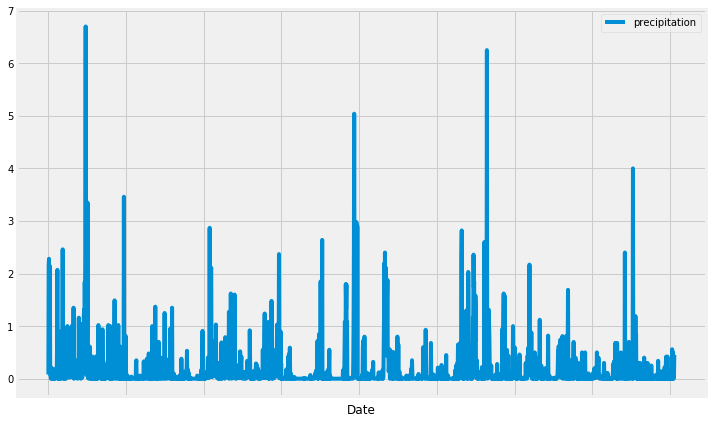

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date_q = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
    
for date in last_date_q:
    last_date_r = date.date
last_date_r = dt.datetime.strptime(last_date_r, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
last_date_year_ago = last_date_r - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_date_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data).dropna()

# Sort the dataframe by date
prcp_data_df.sort_values(by='date').head()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_df.head()
plt.rcParams["figure.figsize"] = (10,6)
prcp_data_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.legend(["precipitation"])
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
station_temp = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_temp

('USC00519281', 54.0, 85.0, 71.66378066378067)

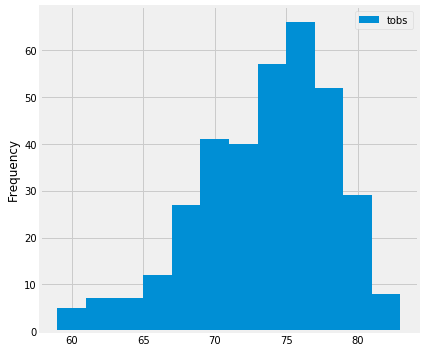

In [15]:
# Choose the station with the highest number of temperature observations.
station_high = station_temp[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Perform a query to retrieve the data and precipitation scores
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station==station_high).\
    filter(Measurement.date >= last_date_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
tobs_data_df = pd.DataFrame(tobs_data).dropna()

# Sort the dataframe by date
tobs_data_df.sort_values(by='date').head()
# Use Pandas Plotting with Matplotlib to plot the data
tobs_data_df.head()
plt.rcParams["figure.figsize"] = (6,5)
tobs_data_df.plot.hist(bins=12)
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(last_date_year_ago, last_date_r))
tmin = calc_temps(last_date_year_ago, last_date_r)[0][0]
tmax = calc_temps(last_date_year_ago, last_date_r)[0][2]
tavg = calc_temps(last_date_year_ago, last_date_r)[0][1]

[(58.0, 74.57894736842105, 87.0)]


Text(0,0.5,'Temp(F)')

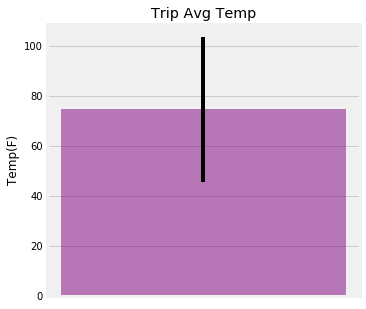

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,5))
plt.bar(1, tavg, color='purple', alpha=0.5, yerr=tmax-tmin)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylabel("Temp(F)")

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Rainfall = func.avg(Measurement.prcp).label("Rainfall")
Rainfall_data = session.query(Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation,\
    func.avg(Measurement.prcp).label("Rainfall")).\
    filter(Measurement.station == Station.station).filter(Measurement.date >= last_date_year_ago).\
    filter(Measurement.date <= last_date_r).group_by(Measurement.station).order_by(Rainfall.desc())
i = 0
for rainf in Rainfall_data:
    print(Rainfall_data[i])
    i = i + 1

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4498776758409787)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.1944159544159545)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1414035087719299)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12571969696969695)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.12137380191693291)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0765)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04494413407821225)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date=dt.date(2017, 8, 17)
end_date=dt.date(2017, 8, 23)
# Use the start and end date to create a range of dates
trip_date= pd.date_range(start_date, end_date, freq='D')
trip_date_mon_day=trip_date.strftime("%m-%d")
# Stip off the year and save a list of %m-%d strings
trip_date_mon_day_year=trip_date.strftime("%Y-%m-%d")
trip_date_mon_day

# Loop through the list of %m-%d strings and calculate the normals for each date

tobs_list=[]
for date in trip_date_mon_day:
    tobs_list.append(*daily_normals(date))
tobs_list

[(69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(tobs_list, columns=['Tmix', 'Tmax','Tavg'])
trip_df
trip_df['Date'] = trip_date_mon_day
trip_df.set_index('Date', inplace=True)
trip_df


,Tmix,Tmax,Tavg
Date,,,
08-17,69.0,76.125000,83.0
08-18,70.0,76.923077,84.0
08-19,69.0,75.946429,85.0
08-20,68.0,76.452830,82.0
08-21,67.0,76.400000,83.0
08-22,69.0,76.471698,84.0
08-23,67.0,76.692308,87.0


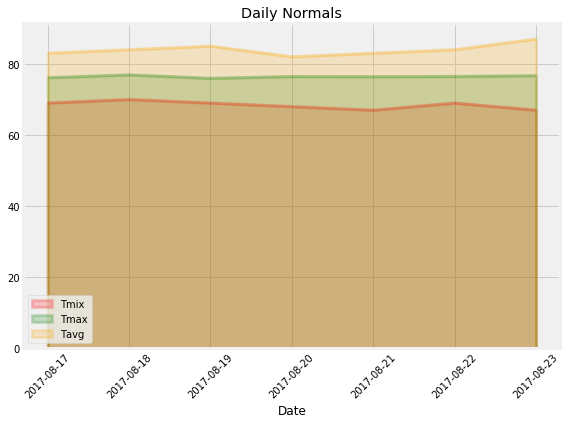

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
trip_plot = trip_df.plot(kind='area', stacked=False, alpha=0.2,
                         color=['red', 'green', 'orange'], 
                         figsize=(8, 6), lw=3)
trip_plot.set_title('Daily Normals')
trip_plot.set_xticks(np.arange(0, len(trip_date_mon_day)))
trip_plot.set_xticklabels(labels=trip_date_mon_day_year, rotation=45)
plt.tight_layout()
plt.show()